# A. Import Python Modules and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import manifold #needed for multidimensional scaling (MDS) and t-SNE
from sklearn import cluster #needed for k-Means clustering
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer #needed for data preparation

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config


# needed for changing Ordinal values - see education
pd.set_option("future.no_silent_downcasting", True)
sklearn.set_config(enable_metadata_routing=True)

# Load the dataset

In [2]:
df = pd.read_csv("./bank.csv")
print('(number of examples, number of attributes): ', df.shape)

(number of examples, number of attributes):  (2000, 17)


# B. Exploratory Data Analysis and Data Preparation¶

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32.0,technician,single,tertiary,no,392,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39.0,technician,divorced,secondary,no,688,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59.0,retired,married,secondary,no,1035,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47.0,blue-collar,married,secondary,no,398,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54.0,retired,married,secondary,no,1004,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [4]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28.0,admin.,single,secondary,no,127,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81.0,retired,married,primary,no,1154,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46.0,services,married,primary,no,4343,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40.0,entrepreneur,married,secondary,no,6403,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


In [5]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,1988.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.753018,1413.663500,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.724358,3131.224213,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,31.000000,1823.000000,11.000000,854.000000,55.000000


balance and pdays has negative values

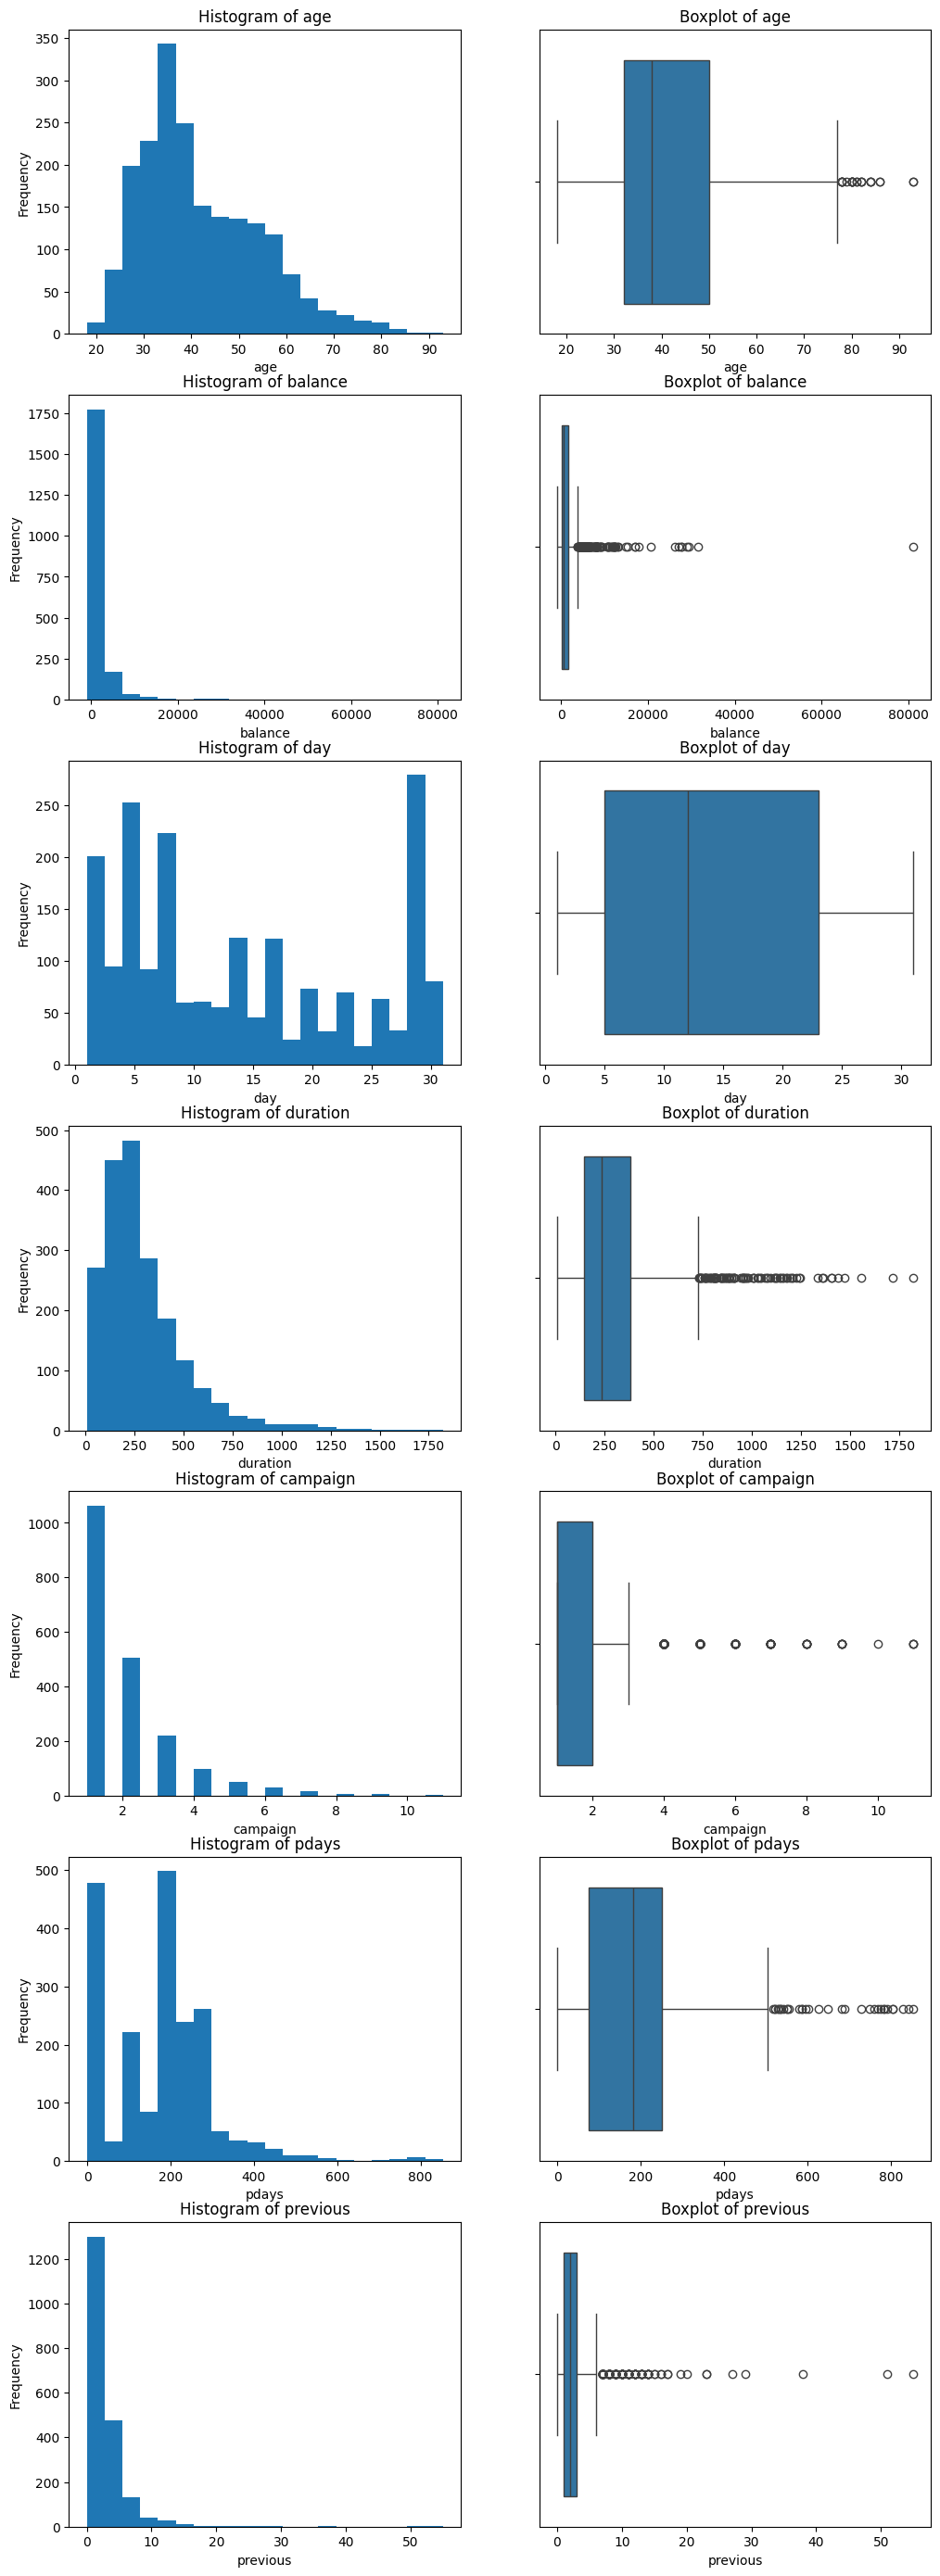

In [6]:
cols = ['age','balance','day','duration','campaign','pdays','previous']

fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12,35))    

for row, column in enumerate(cols):

    axes[row,0].hist(df[column], bins=20)
    axes[row,0].set_title(f'Histogram of {column}')
    axes[row,0].set_xlabel(column)
    axes[row,0].set_ylabel('Frequency')

    # Put boxplot in 2nd col
    sns.boxplot(data=df, x=column, ax=axes[row][1])
    
    axes[row,1].set_title(f'Boxplot of {column}')
    axes[row,1].set_xlabel(column)

plt.show()


**Everything except day has outliers and seems right skewed, so**
1. Use Minmaxscaler for days as its a known range
1. Use RobustScalar for others as they've outliers
1. 

# Data Preparation

## Drop columns that we don't want to avoid data leakage

In [7]:
# Drop columns that we don't want to avoid data leakage
df.drop(columns=['duration'], inplace=True) 
df.drop(columns=['subscribed'], inplace=True) 


## Add mapper for Education

In [8]:
# Create a mapper for education

scale_mapper = {
    "primary": 0,
"secondary":1,
"tertiary":2
}

df['education'] = df['education'].replace(scale_mapper)
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,campaign,pdays,previous,poutcome
1995,20.0,student,single,NaN,no,2785,no,no,cellular,16,sep,2,-1,0,NaN
1996,28.0,admin.,single,1,no,127,no,no,cellular,16,sep,2,-1,0,NaN
1997,81.0,retired,married,0,no,1154,no,no,telephone,17,sep,1,-1,0,NaN
1998,46.0,services,married,0,no,4343,yes,no,NaN,20,sep,1,-1,0,NaN
1999,40.0,entrepreneur,married,1,no,6403,no,no,cellular,22,sep,2,-1,0,NaN


In [9]:
## Encode months using a label encoder

In [10]:
# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'month' column
df['month'] = label_encoder.fit_transform(df['month'])

### Check for Missing Values

In [11]:
### Check for missing values.  .sort_values(ascending=False)
df.isna().sum()[df.isna().sum() > 0].sort_index(ascending=True)


age           12
contact      191
education    104
job           10
poutcome     454
dtype: int64

## Create Imput Missing Values Pipeline
1. Use Median for age
1. Use Mode for Education, Contact and Job
1. Add constant string, NOT_CONTACTED for poutcome

right skewed attributes were age','balance','duration','pdays','previous

In [12]:
### Scale values

In [13]:

numeric_preprocess_imput_age = ColumnTransformer(
    transformers = [
        ("imput_age",SimpleImputer(strategy='median'), ['age'])
    ])

numeric_preprocess_transform_for_right_skew = ColumnTransformer(
    transformers = [
        ("distribution_transform", FunctionTransformer(np.log1p ),['age', 'balance','pdays','previous'])
    ])

numeric_preprocess_scale = ColumnTransformer(
    transformers = [
        ("scale_day",MinMaxScaler(), ['day']),
        ("scale_remaining", RobustScaler(), ['age','balance','campaign','pdays','previous'])
    ])

# combine the above into a pipeline for numeric attributes
numeric_preprocess_pipeline_combined = ColumnTransformer(
    transformers = [
        ("imput",numeric_preprocess_imput_age,['age']),
        ("deal_with_skew", numeric_preprocess_transform_for_right_skew, 'age', 'balance','pdays','previous'),
        ("scale",numeric_preprocess_scale, ['age','day','balance','campaign','pdays','previous']),       
    ])


categorical_preprocessor_missing_values = ColumnTransformer(
    transformers = [
        ("imput_education_job_contact",SimpleImputer(strategy='mode'), ['education','contact','job']),
        ("imput_poutcome",SimpleImputer(strategy='constant', fill_value='NOT_CONTACTED'), ['poutcome'])
    ])

# combine the above into a pipeline for categorical attributes
categorical_preprocess_pipeline_combined = ColumnTransformer(
    transformers = [
        ("process_missing",categorical_preprocessor_missing_values, ['education','contact','job','poutcome']),
        ("onehot_encoding", OneHotEncoder(handle_unknown='ignore'))
    ])

preprocess_pipeline = ColumnTransformer( 
    transformers = [
        ('numeric', numeric_preprocess_pipeline_combined), 
        ('categorical', categorical_preprocess_pipeline_combined)
    ])

In [14]:
X_debug = numeric_preprocess_imput_age.fit_transform(df)
print ('debug',X_debug);

debug [[32.]
 [39.]
 [59.]
 ...
 [81.]
 [46.]
 [40.]]


# D. K-Means Clustering

k = 3

pipe = Pipeline(steps=[
    ('preprocess_pipeline', preprocess_pipeline), 
    ('kMeans', cluster.KMeans(n_clusters=k, n_init=10, max_iter=300))
])

clustering_model = pipe.fit(df)

# Here we use the preprocessing step of the pipeline to get a copy of the dataset with the preprocessing steps applied to it.
preprocessed_data = clustering_model['preprocess'].transform(df)

Misc Workings